This notebook finds the closest infrastructure to the points chosen by the WK-Means algorithm.

Install & import libraries

In [ ]:
!pip install mapbox==0.3.1
!pip install geopandas

In [3]:
import geopandas
import pickle
import pandas as pd
import geopy.distance
from mapbox import Geocoder
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


Set API Token

In [48]:
mapbox_token = 'pk.eyJ1Ijoiamw4NzgxNyIsImEiOiJja244emZ6YjMwZWR0Mm9waWh0d3FpY24zIn0.d4S4s9v5PE93-J3othM21g'
geocoder = Geocoder(access_token=mapbox_token)

Read in WK-Means centroids

In [49]:
pop_centroids = pd.read_pickle('/content/pop_centroids.pkl')
demo_centroids = pd.read_pickle('/content/demo_centroids.pkl')
income_centroids = pd.read_pickle('/content/income_centroids.pkl')

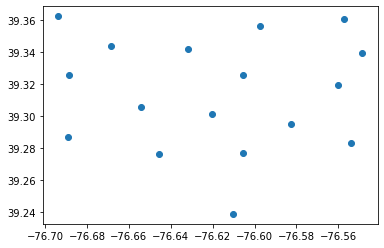

In [51]:
from matplotlib import pyplot as plt
plt.scatter(pop_centroids.lon,pop_centroids.lat)

Calculate Geodesic Distance for WGS84 Ellipsoid

In [60]:
# takes tuple (lat,lon) as coord
def geodesic_distance(coord1,coord2):
  return geopy.distance.distance(coord1, coord2).m

Convert geojson to dataframe & calculate distances

In [81]:
def geojson_to_df(geojson, point):

  df = geopandas.GeoDataFrame(geojson['features'])
  df = df[['place_name','center','properties']]
  df.columns = ['name','coordinates','properties']
  df['new_coord'] = [tuple(x[::-1]) for x in tuple(df['coordinates'])]
  types = [i['category'].split(',')[0] if 'category' in i else 'unknown' for i in df['properties']]
  df['type'] = types

  df['distance'] = df.apply(lambda x: geodesic_distance(point,x.new_coord),axis=1)
  df = df.sort_values('distance')
  
  df = df.drop('properties',axis=1)
  df['old_lat'] = point[0]
  df['old_lon'] = point[1]
  return df

In [82]:
geodesic_distance((-76.675669,39.310396),(39.30604641502461, -76.65418661966287))

14878313.301094571

In [84]:
point

(39.30604641502461, -76.65418661966287)

In [88]:
geojson_to_df(grocery,point)

,name,coordinates,new_coord,type,distance,old_lat,old_lon
1,"Stop Shop Save, 1400 N Monroe St, Baltimore, M...","[-76.648069, 39.304701]","(39.304701, -76.648069)",supermarket,548.396191,39.306046,-76.654187
0,"Shoppers Food Market, 2000 Gwynns Falls Pkwy, ...","[-76.652434, 39.316941]","(39.316941, -76.652434)",supermarket,1218.940762,39.306046,-76.654187
2,"Save-A-Lot, 250 Mcmechen St, Baltimore, Maryla...","[-76.62838, 39.307154]","(39.307154, -76.62838)",supermarket,2229.248566,39.306046,-76.654187
3,"Food Depot, Westside shopping center, Baltimor...","[-76.653937, 39.283]","(39.283, -76.653937)",grocery,2558.729131,39.306046,-76.654187
4,"Price Rite of Baltimore, 1205 West Pratt St., ...","[-76.6361745, 39.2841725]","(39.2841725, -76.6361745)",supermarket,2883.021834,39.306046,-76.654187


Search for nearby infrastructure

In [108]:
df = demo_centroids
locations = []

for idx,i in enumerate(df['lon']):
  point = (df['lat'][idx], df['lon'][idx])

  med_center = geocoder.forward(address="medical center", lon=df['lon'][idx], lat=df['lat'][idx]).geojson()
  mdf = geojson_to_df(med_center,point)  

  pharmacy = geocoder.forward(address="pharmacy", lon=df['lon'][idx], lat=df['lat'][idx]).geojson()
  pdf = geojson_to_df(pharmacy,point)

  grocery = geocoder.forward(address="grocery", lon=df['lon'][idx], lat=df['lat'][idx]).geojson()
  gdf = geojson_to_df(grocery,point)

  com_center = geocoder.forward(address="community center", lon=df['lon'][idx], lat=df['lat'][idx]).geojson()
  cdf = geojson_to_df(com_center,point)

  church = geocoder.forward(address="church", lon=df['lon'][idx], lat=df['lat'][idx]).geojson()
  churchdf = geojson_to_df(church,point)

  school = geocoder.forward(address="school", lon=df['lon'][idx], lat=df['lat'][idx]).geojson()
  sdf = geojson_to_df(school,point)

  uni = geocoder.forward(address="university", lon=df['lon'][idx], lat=df['lat'][idx]).geojson()
  udf = geojson_to_df(uni,point)

  college = geocoder.forward(address="college", lon=df['lon'][idx], lat=df['lat'][idx]).geojson()
  collegedf = geojson_to_df(college,point) 

  clinic = geocoder.forward(address="clinic", lon=df['lon'][idx], lat=df['lat'][idx]).geojson()
  clinicdf = geojson_to_df(clinic,point)

  hospital = geocoder.forward(address="hospital", lon=df['lon'][idx], lat=df['lat'][idx]).geojson()
  hdf = geojson_to_df(hospital,point) 
 
  all_df = [pdf,gdf,cdf,churchdf,sdf,clinicdf,hdf,mdf,udf,collegedf]
  final_df = pd.concat(all_df).reset_index().drop('index',axis=1)
  final_df = final_df.sort_values('distance')
  best = final_df.iloc[0].values
  locations.append(best)

Display the closest infrastructure to the initial WK-Means points

In [109]:
final_points = pd.DataFrame(locations, columns=['name','coordinates','new_coord','type','dist','old_lat','old_lon'])
new_lat = [i[0] for i in final_points.new_coord ]
new_lon = [i[1] for i in final_points.new_coord ]
final_points['new_lat'] = new_lat
final_points['new_lon'] = new_lon
final_points = final_points.drop(['coordinates','new_coord'],axis=1)
final_points

,name,type,dist,old_lat,old_lon,new_lat,new_lon
0,"Deliverance Temple Ministries, 3300 Glen Ave, ...",church,654.710792,39.362011,-76.678306,39.358154,-76.684052
1,"Giant, 6620 Reisterstown Rd, Baltimore, Maryla...",supermarket,423.305116,39.359304,-76.702372,39.357514,-76.706708
2,"Zion Church of the City of Baltimore, 400 E Le...",church,375.634723,39.291574,-76.605850,39.291398,-76.610198
3,"Mt Hattin Baptist Church, 2409 Aisquith St, Ba...",church,306.620616,39.316762,-76.602000,39.316664,-76.598447
4,"Freedom Baptist Church, 3455 Erdman Ave, Balti...",church,633.414688,39.318779,-76.563544,39.318678,-76.570888
5,"Futurecare, 22 S Athol Ave, Baltimore, Marylan...",clinic,207.834143,39.286514,-76.689274,39.284934,-76.690566
6,"Fresh Food Point, 5830 Hillen Rd, Baltimore, M...",grocery,146.328472,39.360662,-76.582857,39.359348,-76.582733
7,"ShopRite of Howard Park, 4601 Liberty Heights ...",supermarket,888.137887,39.322574,-76.695208,39.330573,-76.695357
8,"George W . F Mechen School, Fernhill, Baltimor...",high school,91.619308,39.337699,-76.682058,39.337013,-76.682648
9,"Church of the Redeemed of the Lord, 4321 Old Y...",church,13.546761,39.342690,-76.607097,39.342793,-76.607182


Plot the differences in distance between old points & new points

In [ ]:
from matplotlib import pyplot as plt
old_lon = df['lon'].values
old_lat = df['lat'].values
new_lon = final_points['new_lon'].values
new_lat = final_points['new_lat'].values


fig, ax = plt.subplots(figsize=(10,7));
#white = ax.scatter(lon4,lat4, c='white');
black = ax.scatter(old_lon,old_lat,c='black'); 
red = ax.scatter(new_lon,new_lat,c='red'); 
ax.legend((black,red),('old','new'));
plt.title('Differences in distance (meters) between old & new locations');
plt.xlabel('Longitude');
plt.ylabel('Latitude');

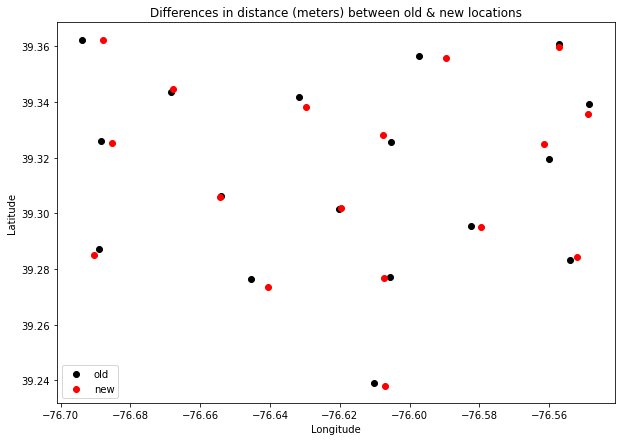

In [ ]:
from matplotlib import pyplot as plt
old_lon = df['lon'].values
old_lat = df['lat'].values
new_lon = final_points['new_lon'].values
new_lat = final_points['new_lat'].values


fig, ax = plt.subplots(figsize=(10,7));
#white = ax.scatter(lon4,lat4, c='white');
black = ax.scatter(old_lon,old_lat,c='black'); 
red = ax.scatter(new_lon,new_lat,c='red'); 
ax.legend((black,red),('old','new'));
plt.title('Differences in distance (meters) between old & new locations');
plt.xlabel('Longitude');
plt.ylabel('Latitude');

Save results as pickle file

In [ ]:
final_points.to_pickle('/content/pop_final_points.pkl')
